# Analysis
This file contains the codes that generate the results we see in the report.

In [1]:
import import_ipynb
import warnings
warnings.filterwarnings('ignore')
from colorit import *
init_colorit()

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
 

# Data Inspection
The datafile contains daily close price for Facebook and Alibaba from the beginning of 2018 to the end of 2020

In [2]:
datafile = 'data.csv'
coint_prices = pd.read_csv(datafile,index_col = 'Date')
coint_prices.head(10)

,BABA,FB
Date,,
2018-01-02,183.649994,181.419998
2018-01-03,184.000000,184.669998
2018-01-04,185.710007,184.330002
2018-01-05,190.699997,186.850006
2018-01-08,190.330002,188.279999
2018-01-09,190.800003,187.869995
2018-01-10,189.789993,187.839996
2018-01-11,188.750000,187.770004
2018-01-12,187.789993,179.369995


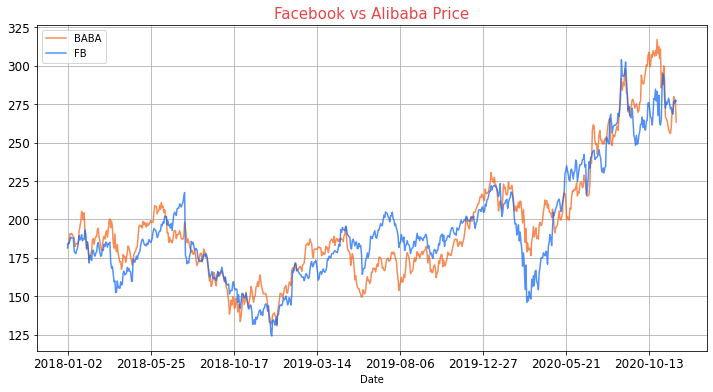

In [3]:
# Plot the price
coint_prices.plot(figsize = (12,6), 
                  fontsize = 12,
                 color = ['#F55C10','#0A63F5'],alpha = 0.7)
plt.title('Facebook vs Alibaba Price',
          fontsize = 15,
         color = '#E64848')
plt.grid(True)

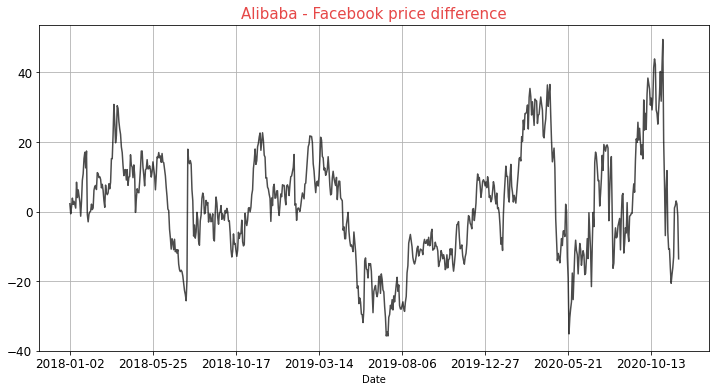

In [4]:
# Plotting the residuals
prices_diff = coint_prices.BABA - coint_prices.FB
prices_diff.plot(figsize = (12,6), 
                  fontsize = 12,
                color = 'black',
                alpha = 0.7)
plt.title('Alibaba - Facebook price difference',
          fontsize = 15,
         color = '#E64848')
plt.grid(True)

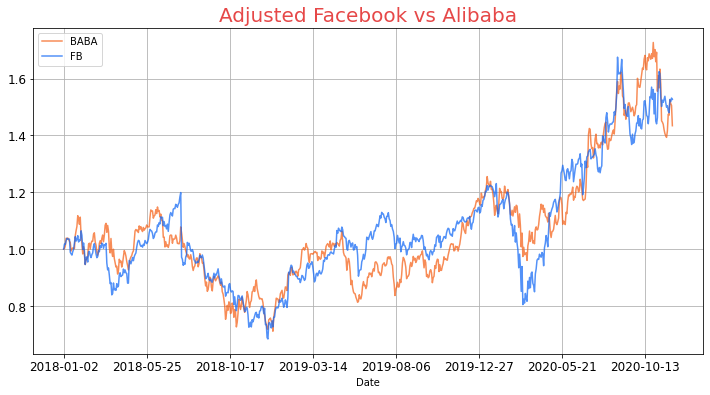

In [5]:
# Adjusted price, both prices starts at 1
coint_prices = coint_prices/coint_prices.iloc[0]
coint_prices.plot(figsize = (12,6), 
                  fontsize = 12,
                 color = ['#F55C10','#0A63F5'],
                  alpha = 0.7)
plt.title('Adjusted Facebook vs Alibaba',fontsize = 20,color = '#E64848')
plt.grid(True)

In [6]:
returns = np.log(coint_prices).diff().dropna()
returns.head()

,BABA,FB
Date,,
2018-01-03,0.001904,0.017756
2018-01-04,0.009251,-0.001843
2018-01-05,0.026515,0.013579
2018-01-08,-0.001942,0.007624
2018-01-09,0.002466,-0.002180


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5da2be910>,
      dtype=object)

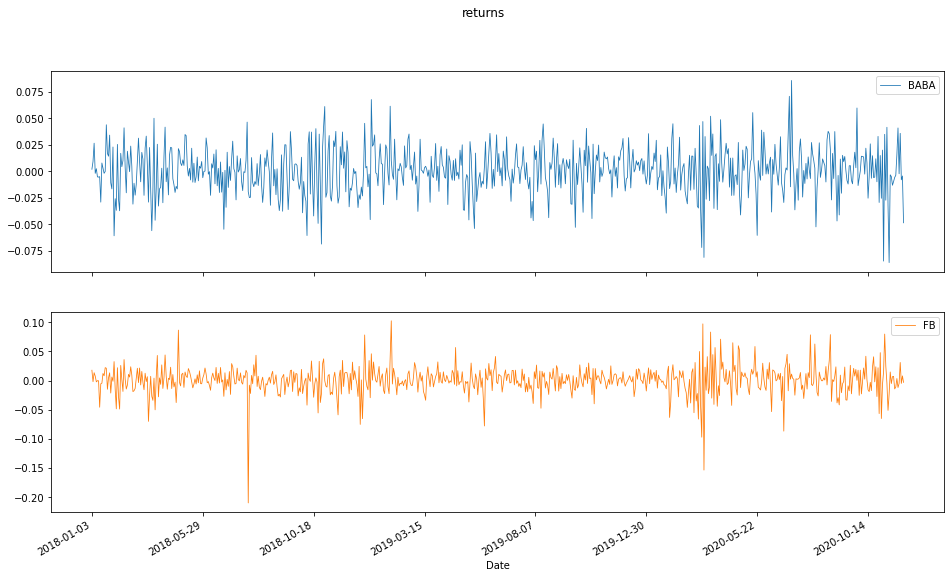

In [7]:
# Plot the returns
returns.plot(figsize = (16,9),subplots = True, linewidth = 0.8, title = 'returns')

In [9]:
from utility import VAR

importing Jupyter notebook from utility.ipynb


In [10]:
model = VAR(returns, lag = 1)
model.report()

Estimate Coefficient           SD of Estimate            \
                              BABA        FB           BABA        FB   
(Lag_1, BABA)             0.045013 -0.030688       0.043083  0.047057   
(Lag_1, FB)              -0.073990 -0.099768       0.039143  0.042752   
constant                  0.000510  0.000652       0.000821  0.000897   

              t-Statistic            
                     BABA        FB  
(Lag_1, BABA)    1.044792 -0.652155  
(Lag_1, FB)     -1.890267 -2.333627  
constant         0.620490  0.727090

In [11]:
model.p_value < 0.05

,BABA,FB
"(Lag_1, BABA)",False,False
"(Lag_1, FB)",False,True
constant,False,False


In [12]:
model.IC(lag = 10,)

,AIC,BIC
Lag,,
1,-15.339415,-15.301785
2,-15.332764,-15.270047
3,-15.331255,-15.243451
4,-15.321393,-15.208503
5,-15.312210,-15.174233
6,-15.308782,-15.145718
7,-15.306070,-15.117920
8,-15.309380,-15.096142
9,-15.303473,-15.065149


In [13]:
model.stability()

Stability status: [o] STABLE


# Cointegration

In [14]:
coint_prices = pd.read_csv(datafile, index_col = 'Date')
FB = pd.DataFrame(coint_prices['FB'])
BABA = pd.DataFrame(coint_prices['BABA'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5d5a23790>,
      dtype=object)

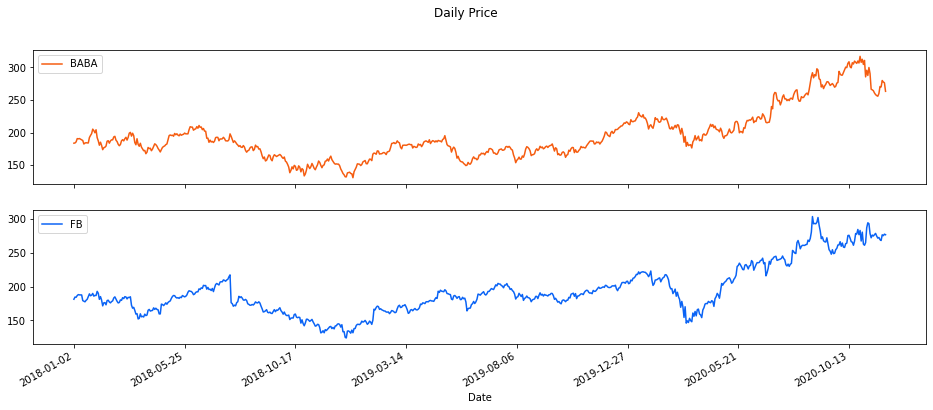

In [15]:
coint_prices.plot(figsize = (16,6),
                  color = ['#F55C10','#0A63F5'],
                  subplots = True,
                 title = 'Daily Price',)

# Engle Granger  
## y = FB | x = BABA

In [16]:
from utility import LinearRegression as LR

In [17]:
model = LR(x = BABA, y = FB) 
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,FB,FB,FB
BABA,0.864299,0.013810,62.585632
constant,24.744947,2.749676,8.999223


In [18]:
model.coef

,FB
BABA,0.864299
constant,24.744947


In [19]:
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.head()

,Residual(FB - β·BABA)
Date,
2018-01-02,-2.053493
2018-01-03,0.893997
2018-01-04,-0.923957
2018-01-05,-2.716797
2018-01-08,-0.967018


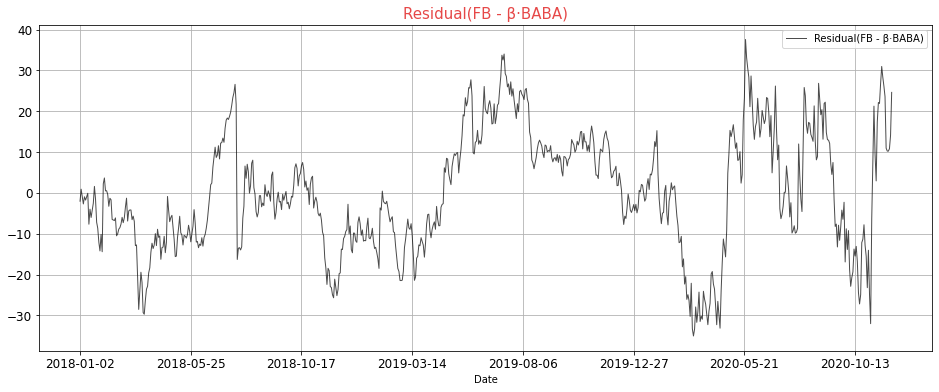

In [20]:
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.title('Residual(FB - β·BABA)',
         color = '#E64848',
         fontsize = 15)
plt.grid(True)

In [21]:
from utility import ADF

In [22]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.15444074] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


,Estimate Coefficient,SD of Estimate,t-Statistic
,(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA))
"(Lag 1, Residual(FB - β·BABA))",-0.047907,0.011532,-4.154441
"(Lag 1, ΔResidual(FB - β·BABA))",0.030824,0.037194,0.828745
constant,0.030233,0.164179,0.184150



$$ {  ΔPA_{𝑡}=𝜑ΔPB_{𝑡} − (1−𝛼)\hat{𝑒}_{𝑡−1}+𝜀_{𝑡} }$$

$$ { ΔFB𝑡 = 𝜑ΔBABA_{𝑡} −(1−𝛼)CointResidual(FB \; on \; BABA_{𝑡−1}) + 𝜀_{t} }$$

In [23]:
Δy = pd.DataFrame(FB).diff().dropna().add_prefix('Δ')
Δx = pd.DataFrame(BABA).diff().dropna().add_prefix('Δ')

X = Δx.join(residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))

model = LR(X, Δy,add_const = False)
model.report()


,Estimate Coefficient,SD of Estimate,t-Statistic
,ΔFB,ΔFB,ΔFB
ΔBABA,0.510556,0.034257,14.903664
"(Lag 1, Residual(FB - β·BABA))",-0.040760,0.010647,-3.828437


In [24]:
model.p_value < 0.05

,ΔFB
ΔBABA,True
"(Lag 1, Residual(FB - β·BABA))",True


# Engle Granger  
## y = BABA | x = FB

In [25]:
model = LR(x = FB, y = BABA,add_const = True) 
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,BABA,BABA,BABA
FB,0.974831,0.015576,62.585632
constant,6.633532,3.067732,2.162357


In [26]:
residuals = pd.DataFrame(model.error.reshape(1,len(BABA))[0],
                         index = BABA.index,
                         columns = ['Residual(BABA - β·FB)'])
residuals.head()

,Residual(BABA - β·FB)
Date,
2018-01-02,0.162663
2018-01-03,-2.655531
2018-01-04,-0.614085
2018-01-05,1.919327
2018-01-08,0.155331


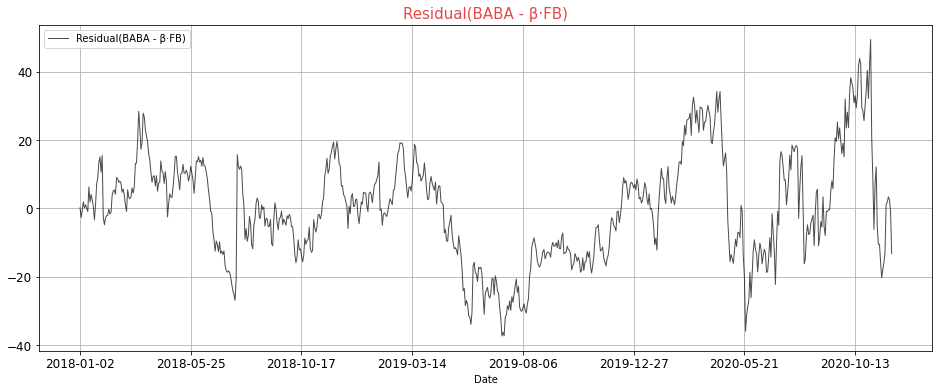

In [27]:
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.title('Residual(BABA - β·FB)',
          color = '#E64848',
         fontsize = 15)
plt.grid(True)

In [28]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.24848594] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


,Estimate Coefficient,SD of Estimate,t-Statistic
,(ΔResidual(BABA - β·FB)),(ΔResidual(BABA - β·FB)),(ΔResidual(BABA - β·FB))
"(Lag 1, Residual(BABA - β·FB))",-0.047918,0.011279,-4.248486
"(Lag 1, ΔResidual(BABA - β·FB))",0.042808,0.037176,1.151512
constant,-0.013579,0.170938,-0.079441


In [29]:
Δy = pd.DataFrame(BABA).diff().dropna().add_prefix('Δ')
Δx = pd.DataFrame(FB).diff().dropna().add_prefix('Δ')

X = Δx.join(residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))

model = LR(X, Δy,add_const = False)
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,ΔBABA,ΔBABA,ΔBABA
ΔFB,0.456371,0.030571,14.928102
"(Lag 1, Residual(BABA - β·FB))",-0.031365,0.009481,-3.308126


In [30]:
model.p_value < 0.05

,ΔBABA
ΔFB,True
"(Lag 1, Residual(BABA - β·FB))",True


# FB - BABA signal generating

In [31]:
model = LR(x = BABA, y = FB)
model.report()


,Estimate Coefficient,SD of Estimate,t-Statistic
,FB,FB,FB
BABA,0.864299,0.013810,62.585632
constant,24.744947,2.749676,8.999223


In [32]:
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.head()

,Residual(FB - β·BABA)
Date,
2018-01-02,-2.053493
2018-01-03,0.893997
2018-01-04,-0.923957
2018-01-05,-2.716797
2018-01-08,-0.967018


In [33]:
model = VAR(residuals, lag = 1)
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,Residual(FB - β·BABA),Residual(FB - β·BABA),Residual(FB - β·BABA)
"(Lag_1, Residual(FB - β·BABA))",0.953556,0.011375,83.828855
constant,0.031963,0.163763,0.195176


In [34]:
B = model.coef.values[0][0]
C = model.coef.values[1][0]
mu = C/(1-B)
tau = 1/252
SSE = np.sum(model.error**2)
sigma_eq = ((SSE*tau/(1-B**2))**0.5).values[0]
mu, sigma_eq

(0.6882025019775284, 25.104003073237713)

# Z = 1

mu:           0.688203 
upper bound: 25.79220557521524 
lower bound: -24.415800571260185


Text(0.5, 1.0, 'Signals (Z = 1)')

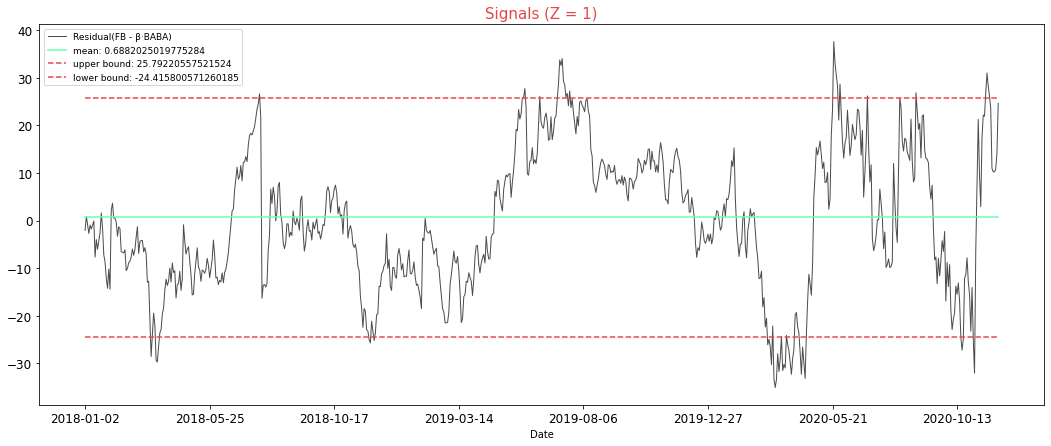

In [35]:
Z = 1
upper_bound = mu +  Z * sigma_eq
lower_bound = mu -  Z * sigma_eq
print("mu: {:18f} \nupper bound: {} \nlower bound: {}".format(mu, upper_bound, lower_bound))

residuals.plot(figsize = (18,7),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.plot(np.ones(len(residuals))*mu,
        color = '#66ffb3', label = 'mean: '+ str(mu))

plt.plot(np.ones(len(residuals))*(mu+Z*sigma_eq),
         '--', color = '#E64848', label = 'upper bound: '+str(mu+Z*sigma_eq))
plt.plot(np.ones(len(residuals))*(mu-Z*sigma_eq),
         '--',color = '#E64848', label = 'lower bound: '+str(mu-Z*sigma_eq))
plt.legend(fontsize = 9)

plt.title('Signals (Z = {})'.format(Z),
          color = '#E64848',
         fontsize = 15)


====================Cumulative Profit====================
0     30.532383
1     73.419449
2    104.523171
3    131.573661
4    162.453535
5    203.895589
6    231.321956
7    262.797841
dtype: float64


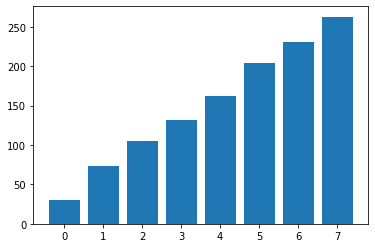

In [36]:
from utility import Backtest
df = pd.read_csv(datafile, index_col = 'Date')
df['res_past'] = residuals.shift().fillna(0)
df['res'] = residuals
test = Backtest(df,upper_bound, lower_bound, mu)
trading_rec = test.Signal_generation(daily=False)
test.PL(trading_rec, beta = 0.864299)

In [37]:
trading_rec

,BABA,FB,res_past,res,action
Date,,,,,
2018-03-20,198.949997,168.149994,-20.317073,-28.547278,entry2
2018-06-21,202.210007,201.500000,-0.989369,1.985104,exit
2018-07-24,189.000000,214.669998,24.506539,26.572501,entry1
2018-07-26,194.179993,176.259995,21.641100,-16.314566,exit
2018-11-27,156.460007,135.000000,-23.204257,-24.973207,entry2
2019-04-25,187.880005,193.259995,-2.639378,6.130508,exit
2019-05-30,151.070007,183.009995,25.656716,27.695360,entry1
2019-12-11,204.639999,202.259995,2.876275,0.644858,exit
2020-03-09,197.660004,169.500000,-20.525140,-26.082332,entry2


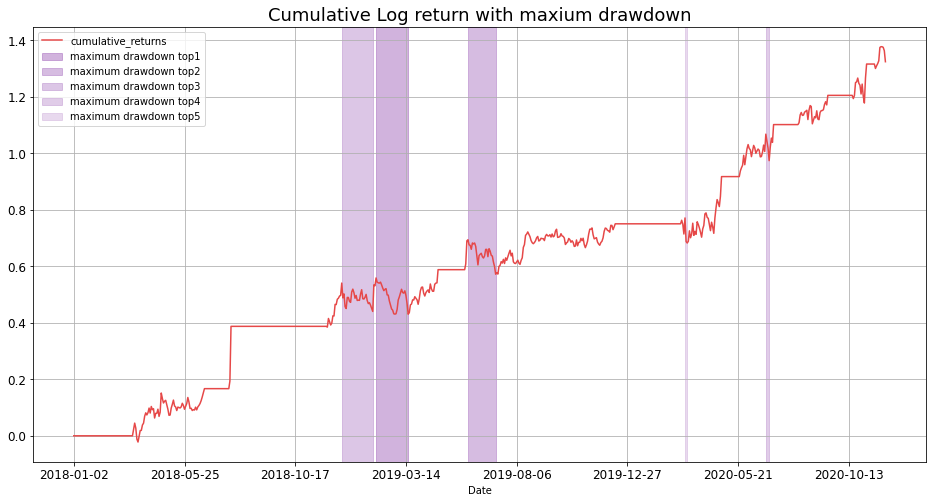

In [38]:
trading_d_rec = test.Signal_generation()
trading_d_rec = test.Returns(trading_d_rec, beta = 0.864299)
test.plot(trading_d_rec)


In [39]:
# Rolling Beta

In [40]:
sp = pd.read_csv('SP500.csv',index_col = 'Date')
sp

,SP500,SP500 Ret,Port Ret,Rolling_beta_1_week,Rolling_beta_2_week,Rolling_1_month
Date,,,,,,
2018-03-21,2711.929932,-0.000802,0.023351,NaN,NaN,NaN
2018-03-22,2643.689941,-0.011068,0.021540,NaN,NaN,NaN
2018-03-23,2588.260010,-0.009203,-0.017623,NaN,NaN,NaN
2018-03-26,2658.550049,0.011637,-0.039064,NaN,NaN,NaN
2018-03-27,2612.620117,-0.007569,-0.010248,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-11-20,3557.540039,-0.002960,0.047292,0.077463,0.113727,0.090500
2020-11-23,3577.590088,0.002441,0.002707,0.035353,0.108479,0.080722
2020-11-24,3635.409912,0.006963,-0.000182,0.060995,0.108450,0.077760


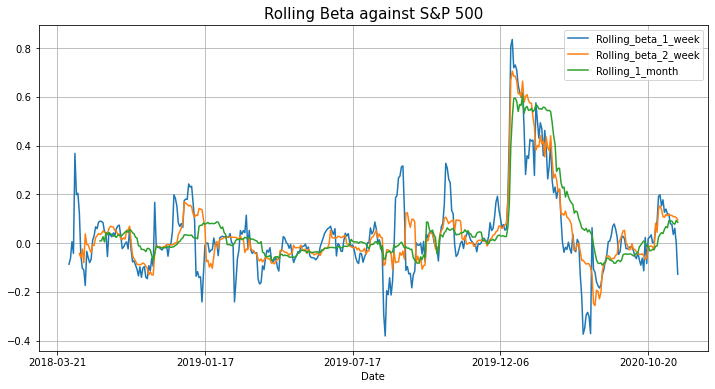

In [41]:
sp[['Rolling_beta_1_week','Rolling_beta_2_week','Rolling_1_month']].plot(figsize = (12,6),)
plt.title('Rolling Beta against S&P 500',fontsize = 15)
plt.grid(True)

# z = 1.03

mu:           0.688203 
upper bound: 26.545325667412374 
lower bound: -25.168920663457317


Text(0.5, 1.0, 'Signals (Z = 1.03)')

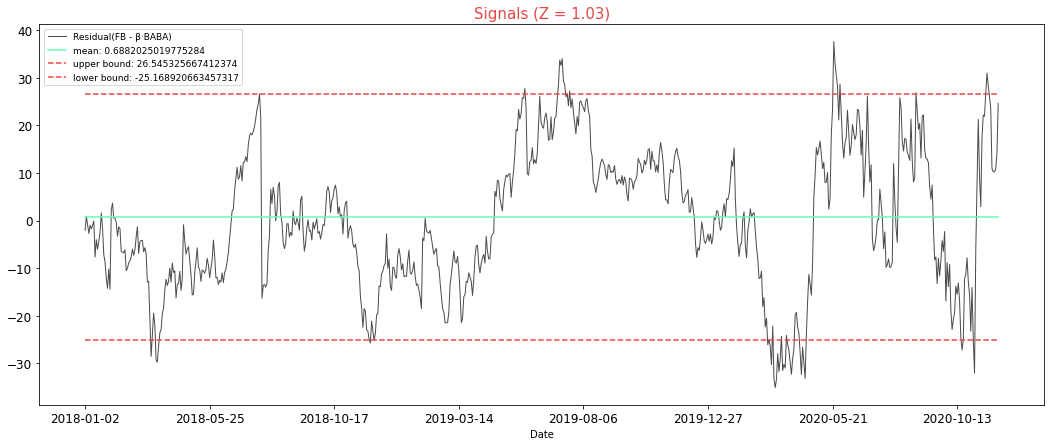

In [42]:
#1.03
Z = 1.03
upper_bound = mu +  Z * sigma_eq
lower_bound = mu -  Z * sigma_eq
print("mu: {:18f} \nupper bound: {} \nlower bound: {}".format(mu, upper_bound, lower_bound))

residuals.plot(figsize = (18,7),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.plot(np.ones(len(residuals))*mu,
        color = '#66ffb3', label = 'mean: '+ str(mu))

plt.plot(np.ones(len(residuals))*(mu+Z*sigma_eq),
         '--', color = '#E64848', label = 'upper bound: '+str(mu+Z*sigma_eq))
plt.plot(np.ones(len(residuals))*(mu-Z*sigma_eq),
         '--',color = '#E64848', label = 'lower bound: '+str(mu-Z*sigma_eq))
plt.legend(fontsize = 9)

plt.title('Signals (Z = {})'.format(Z),
          color = '#E64848',
         fontsize = 15)


====================Cumulative Profit====================
0     30.532383
1     73.419449
2    105.252348
3    132.302839
4    163.182712
5    204.624766
6    233.070189
7    267.330199
dtype: float64


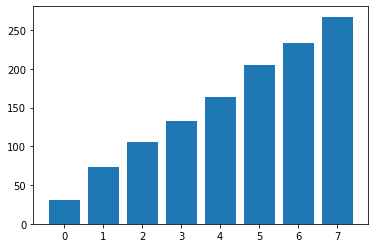

In [43]:
df = pd.read_csv(datafile, index_col = 'Date')
df['res_past'] = residuals.shift().fillna(0)
df['res'] = residuals
test = Backtest(df,upper_bound, lower_bound, mu)
trading_rec = test.Signal_generation(daily=False)
test.PL(trading_rec, beta = 0.864299)

In [44]:
trading_rec

,BABA,FB,res_past,res,action
Date,,,,,
2018-03-20,198.949997,168.149994,-20.317073,-28.547278,entry2
2018-06-21,202.210007,201.500000,-0.989369,1.985104,exit
2018-07-24,189.000000,214.669998,24.506539,26.572501,entry1
2018-07-26,194.179993,176.259995,21.641100,-16.314566,exit
2018-11-28,159.339996,136.759995,-24.973207,-25.702385,entry2
2019-04-25,187.880005,193.259995,-2.639378,6.130508,exit
2019-05-30,151.070007,183.009995,25.656716,27.695360,entry1
2019-12-11,204.639999,202.259995,2.876275,0.644858,exit
2020-03-09,197.660004,169.500000,-20.525140,-26.082332,entry2


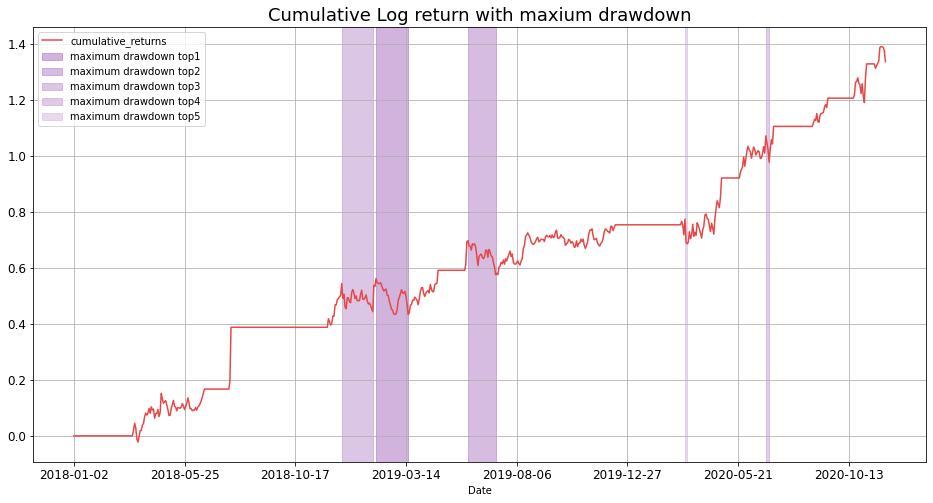

In [45]:
trading_d_rec = test.Signal_generation()
trading_d_rec = test.Returns(trading_d_rec, beta = 0.864299)
test.plot(trading_d_rec)


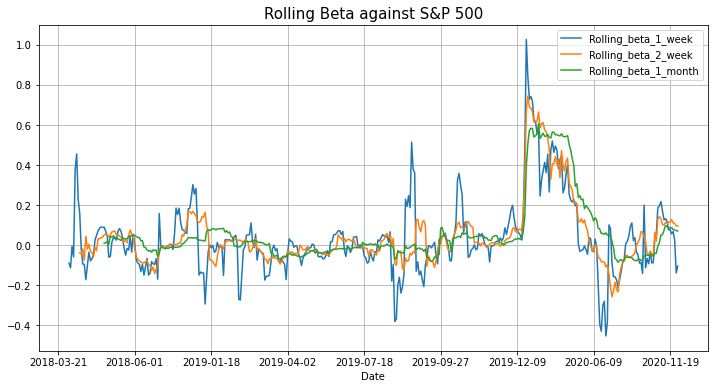

In [46]:
sp = pd.read_csv('SP500Z103.csv',index_col = 'Date')
sp[['Rolling_beta_1_week','Rolling_beta_2_week','Rolling_beta_1_month']].plot(figsize = (12,6),)
plt.title('Rolling Beta against S&P 500',fontsize = 15)
plt.grid(True)

# z = 0.3

mu:           0.688203 
upper bound: 8.219403423948842 
lower bound: -6.842998419993785


Text(0.5, 1.0, 'Signals (Z = 0.3)')

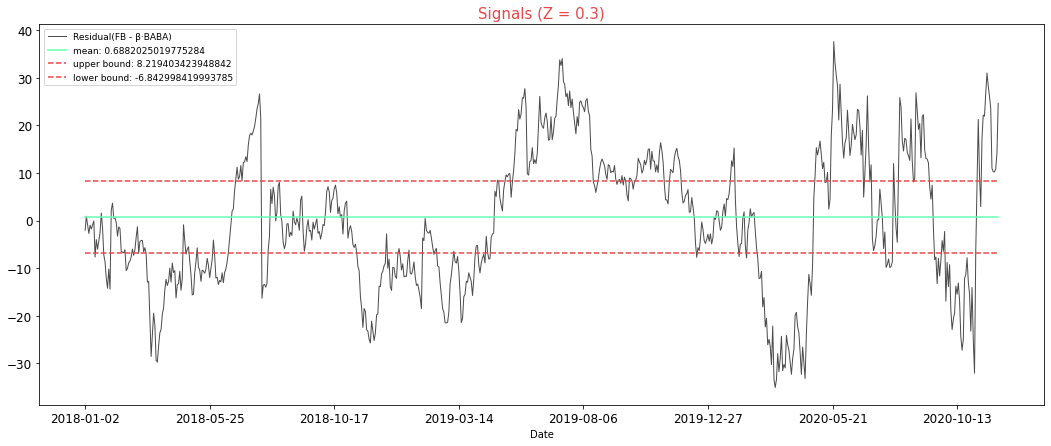

In [47]:
Z = 0.3
upper_bound = mu +  Z * sigma_eq
lower_bound = mu -  Z * sigma_eq
print("mu: {:18f} \nupper bound: {} \nlower bound: {}".format(mu, upper_bound, lower_bound))

residuals.plot(figsize = (18,7),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.plot(np.ones(len(residuals))*mu,
        color = '#66ffb3', label = 'mean: '+ str(mu))

plt.plot(np.ones(len(residuals))*(mu+Z*sigma_eq),
         '--', color = '#E64848', label = 'upper bound: '+str(mu+Z*sigma_eq))
plt.plot(np.ones(len(residuals))*(mu-Z*sigma_eq),
         '--',color = '#E64848', label = 'lower bound: '+str(mu-Z*sigma_eq))
plt.legend(fontsize = 9)

plt.title('Signals (Z = {})'.format(Z),
          color = '#E64848',
         fontsize = 15)


====================Cumulative Profit====================
0       9.258398
1      18.659219
2      31.167449
3      56.292915
4      72.043069
5      79.861163
6      89.657493
7      99.499108
8     108.874270
9     119.189966
10    131.946277
11    145.259974
12    167.073263
13    179.602458
14    194.885127
dtype: float64


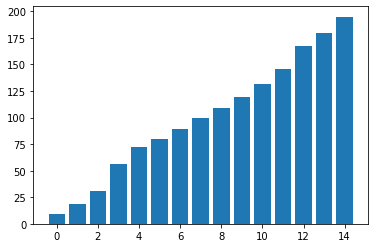

In [48]:
df = pd.read_csv(datafile, index_col = 'Date')
df['res_past'] = residuals.shift().fillna(0)
df['res'] = residuals
test = Backtest(df,upper_bound, lower_bound, mu)
trading_rec = test.Signal_generation(daily=False)
test.PL(trading_rec, beta = 0.864299)

In [49]:
trading_rec

,BABA,FB,res_past,res,action
Date,,,,,
2018-01-12,187.789993,179.369995,-0.111418,-7.681694,entry2
2018-01-22,184.020004,185.369995,-2.529226,1.576704,exit
2018-01-24,195.529999,186.550003,-1.582392,-7.191367,entry2
2018-02-01,192.220001,193.089996,-14.422627,2.209455,exit
2018-02-20,187.190002,176.009995,-6.139419,-10.523123,entry2
2018-06-21,202.210007,201.500000,-0.989369,1.985104,exit
2018-06-26,191.419998,199.000000,6.307836,8.810900,entry1
2018-07-26,194.179993,176.259995,21.641100,-16.314566,exit
2018-11-13,146.979996,142.160004,-6.634163,-9.619637,entry2


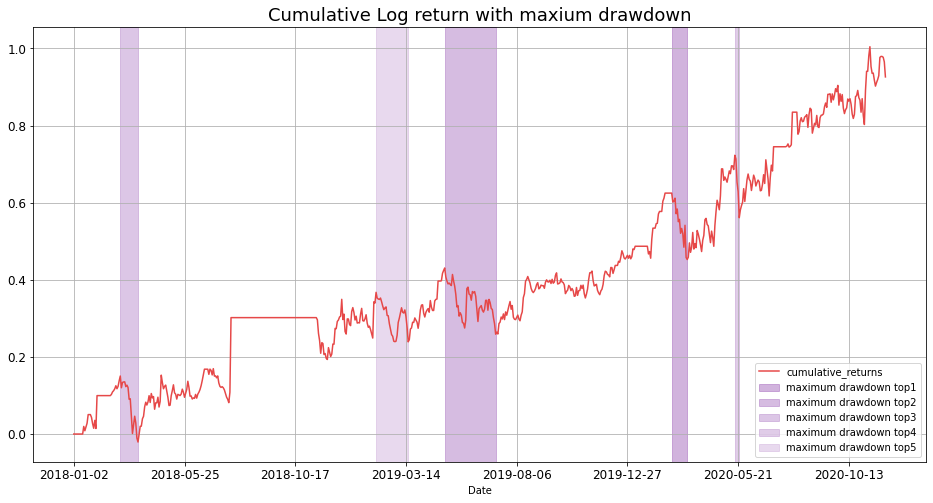

In [50]:
trading_d_rec = test.Signal_generation()
trading_d_rec
trading_d_rec = test.Returns(trading_d_rec, beta = 0.864299)
test.plot(trading_d_rec)
pd.DataFrame(trading_d_rec.returns).to_csv('ret_z03.csv')

In [51]:
sp = pd.read_csv('SP500Z03.csv',index_col = 'Date',encoding='ISO-8859-1')
sp.columns = ['SP500', 'SP500 Ret', 'returns', 'Rolling_beta_1_week',
       'Rolling_beta_2_week', 'Rolling_beta_1_month']
sp.head()

,SP500,SP500 Ret,returns,Rolling_beta_1_week,Rolling_beta_2_week,Rolling_beta_1_month
Date,,,,,,
2018-01-16,2776.419922,-0.001533,0.019692,NaN,NaN,NaN
2018-01-17,2802.560059,0.004070,-0.011188,NaN,NaN,NaN
2018-01-18,2798.030029,-0.000703,0.009636,NaN,NaN,NaN
2018-01-19,2810.300049,0.001900,0.009895,NaN,NaN,NaN
2018-01-22,2832.969971,0.003489,0.022397,NaN,NaN,NaN


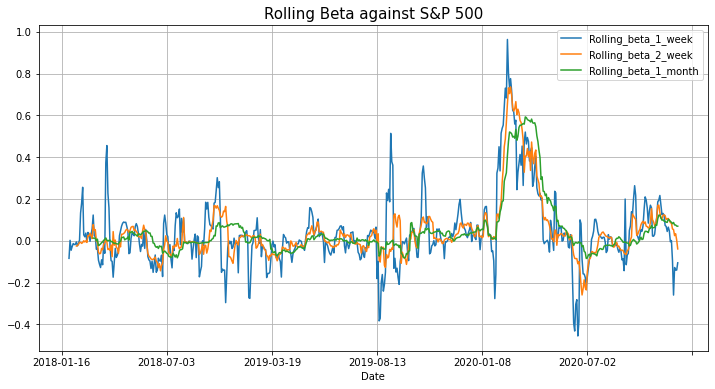

In [52]:
sp[['Rolling_beta_1_week','Rolling_beta_2_week','Rolling_beta_1_month']].plot(figsize = (12,6),)
plt.title('Rolling Beta against S&P 500',fontsize = 15)
plt.grid(True)

# Rolling Beta_coint

In [53]:
datafile = 'data2.csv'
coint_prices = pd.read_csv(datafile,index_col = 'Date')
coint_prices.tail(10)

,BABA,FB
Date,,
2020-12-16,261.890015,275.670013
2020-12-17,264.429993,274.480011
2020-12-18,260.000000,276.399994
2020-12-21,260.429993,272.790009
2020-12-22,255.830002,267.089996
2020-12-23,256.179993,268.109985
2020-12-24,222.000000,267.399994
2020-12-28,222.360001,277.000000
2020-12-29,236.259995,276.779999


In [54]:
coint_prices = pd.read_csv(datafile, index_col = 'Date')
FB = pd.DataFrame(coint_prices['FB'])
BABA = pd.DataFrame(coint_prices['BABA'])

In [55]:
model = LR(x = BABA, y = FB) 
model.report()

,Estimate Coefficient,SD of Estimate,t-Statistic
,FB,FB,FB
BABA,0.894459,0.014181,63.076613
constant,19.816957,2.852997,6.946013


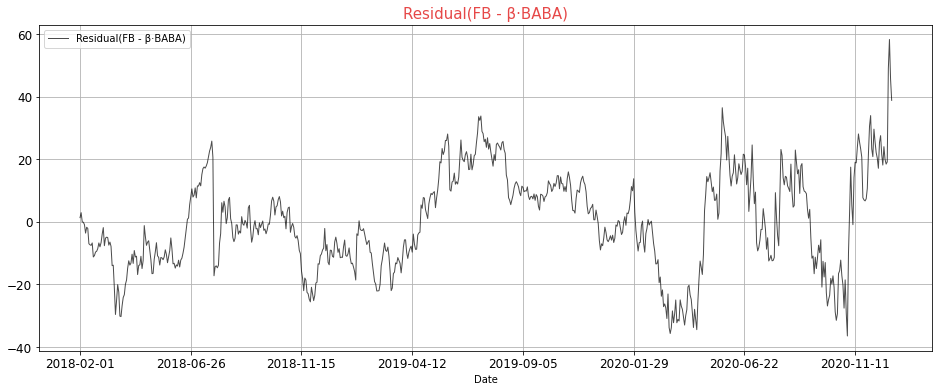

In [56]:
residuals = pd.DataFrame(model.error.reshape(1,len(FB))[0],
                         index = BABA.index,
                         columns = ['Residual(FB - β·BABA)'])
residuals.plot(figsize = (16,6),
              color = 'black',alpha = 0.7,
              fontsize = 12,linewidth = 1)
plt.title('Residual(FB - β·BABA)',
         color = '#E64848',
         fontsize = 15)
plt.grid(True)

In [57]:
adf_test = ADF(residuals)
adf_test.report()

The T-value is [-4.04219767] which is lower than -3.45
[*]We reject the  𝐻0  hypothesis of unit root. The residuals are stationary.


,Estimate Coefficient,SD of Estimate,t-Statistic
,(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA)),(ΔResidual(FB - β·BABA))
"(Lag 1, Residual(FB - β·BABA))",-0.046338,0.011464,-4.042198
"(Lag 1, ΔResidual(FB - β·BABA))",0.059493,0.037226,1.598149
constant,0.042902,0.172465,0.248759


In [58]:
Δy = pd.DataFrame(FB).diff().dropna().add_prefix('Δ')
Δx = pd.DataFrame(BABA).diff().dropna().add_prefix('Δ')

X = Δx.join(residuals.shift(1).dropna().add_prefix('(Lag 1, ').add_suffix(')'))

model = LR(X, Δy,add_const = False)
model.report()


,Estimate Coefficient,SD of Estimate,t-Statistic
,ΔFB,ΔFB,ΔFB
ΔBABA,0.470399,0.033576,14.009931
"(Lag 1, Residual(FB - β·BABA))",-0.036619,0.010246,-3.573904


In [59]:
model.p_value < 0.05

,ΔFB
ΔBABA,True
"(Lag 1, Residual(FB - β·BABA))",True
